# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import colors
import sdf
import re
import imageio as imageio
import glob
import tqdm
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)


# Parameters

## Physical Constants

In [2]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

## Constants From Simulation

In [3]:
DATA_DIR = "run_4"
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

The parameters which we want to extract are:
* Wavelength: `lambda`
* Laser Time: `las_time`
* Vector Potential: `a0`
* The density factor: `factor`
* Number of Cells: `nx`
* Simulation End Time: `t_end`
* Size of Box: `x_min`
* dt: `dt_snapshot`

In [4]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [5]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

Values from input.deck:
lambda0 =  1e-06
laser_time =  20
t_end =  40
dt_snapshot =  8e-17
a0 =  1.0
factor =  4
nx =  16000
x_min =  -20


## Calculated Constants

In [6]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

Calculated Values for the simulation are:
omega0 =  1883651567308853.2
tau =  3.3356409519815205e-15
nc =  1.1143269197457677e+27
Er =  3210701072782.3525
n0 =  4.457307678983071e+27


## Values for FT

In [7]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [8]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

41.69551189976901

## Other Variables

In [9]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

1669

In [10]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

# Plots

In [11]:
def get_field(id, component="y"):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        "x": raw_data.Electric_Field_Ex,
        "y": raw_data.Electric_Field_Ey,
        "z": raw_data.Electric_Field_Ez,
    }
    field = comp[component].data
    return field


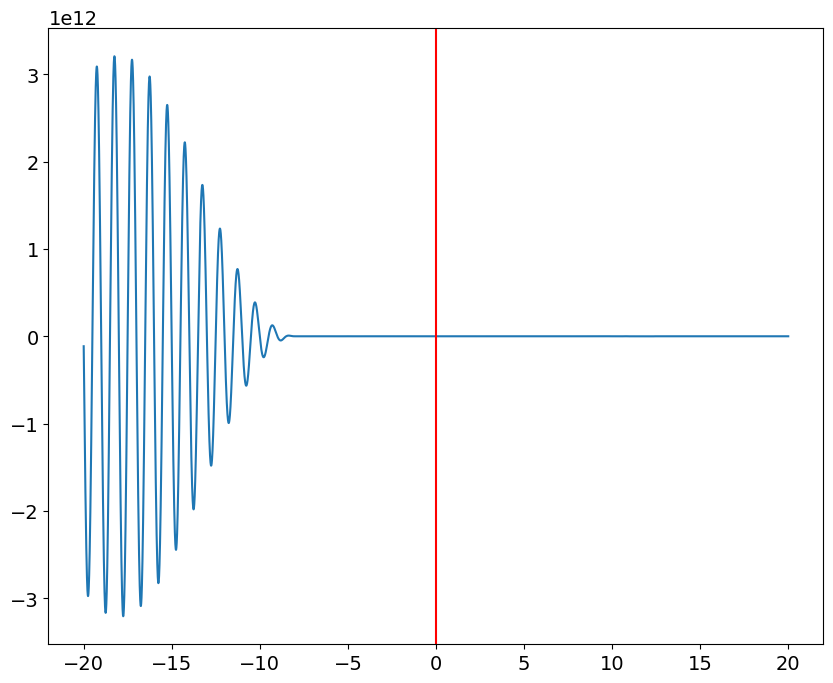

In [12]:
Ey = get_field(500)
plt.plot(X, Ey)
plt.axvline(0, color="red")
plt.show()


In [37]:
Et0 = np.zeros(len(ALL_FILES))
Et1 = np.zeros(len(ALL_FILES))
Et2 = np.zeros(len(ALL_FILES))
d = np.zeros((len(ALL_FILES), NX))
for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
    data = sdf.read(ALL_FILES[i])
    ey = data.Electric_Field_Ey.data
    Et0[i] = ey[0]
    Et1[i] = ey[4000]
    Et2[i] = ey[8000]
    d[i] = data.Derived_Number_Density_Electron.data


Getting Data...: 100%|██████████| 1669/1669 [00:07<00:00, 217.32it/s]


In [38]:
d.shape, Et0.shape

((1669, 16000), (1669,))

In [39]:
d = d/nc

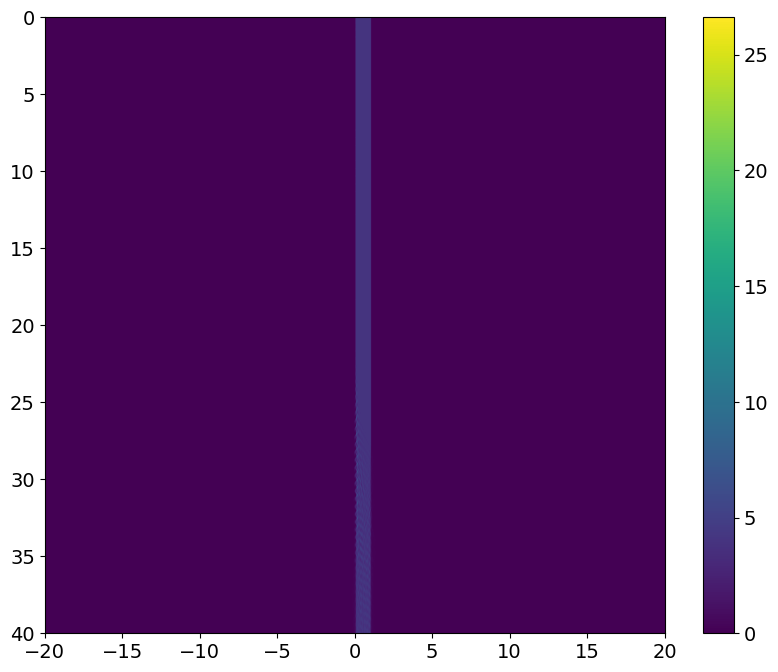

In [40]:
EXTENT = [X_MIN,-X_MIN,T_MAX,0]
plt.imshow(d, aspect="auto", extent=EXTENT)
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

In [41]:
d.shape

(1669, 16000)

In [67]:
np.where(d[1]>FACTOR)[0]

array([8003, 8004, 8005, 8009, 8011, 8014, 8016, 8017, 8022, 8026, 8029,
       8031, 8032, 8034, 8038, 8039, 8041, 8045, 8046, 8052, 8055, 8058,
       8059, 8060, 8062, 8063, 8067, 8070, 8071, 8072, 8074, 8075, 8079,
       8080, 8083, 8086, 8087, 8090, 8094, 8095, 8098, 8102, 8103, 8107,
       8110, 8111, 8113, 8116, 8117, 8121, 8124, 8127, 8128, 8132, 8135,
       8137, 8138, 8140, 8141, 8145, 8151, 8154, 8155, 8156, 8159, 8163,
       8164, 8166, 8169, 8170, 8171, 8172, 8178, 8180, 8181, 8182, 8185,
       8186, 8187, 8191, 8193, 8194, 8197, 8201, 8203, 8204, 8207, 8208,
       8212, 8213, 8216, 8219, 8220, 8223, 8225, 8227, 8228, 8231, 8233,
       8234, 8237, 8239, 8240, 8244, 8245, 8252, 8256, 8258, 8260, 8265,
       8266, 8269, 8272, 8273, 8277, 8279, 8280, 8281, 8283, 8284, 8288,
       8290, 8293, 8300, 8302, 8306, 8307, 8314, 8317, 8319, 8320, 8323,
       8326, 8329, 8330, 8334, 8337, 8340, 8341, 8342, 8343, 8348, 8349,
       8352, 8357, 8360, 8361, 8362, 8368, 8370, 83

In [74]:
first = np.zeros(d.shape[0])
last = np.zeros(d.shape[0])
for i in range(d.shape[0]):
    nonzeros = np.where(d[i]>1)[0]
    if len(nonzeros) > 0:
            
        first[i] = nonzeros[0]
        last[i] = nonzeros[-1]

Text(0.5, 1.0, 'First Node with $n=n_c$')

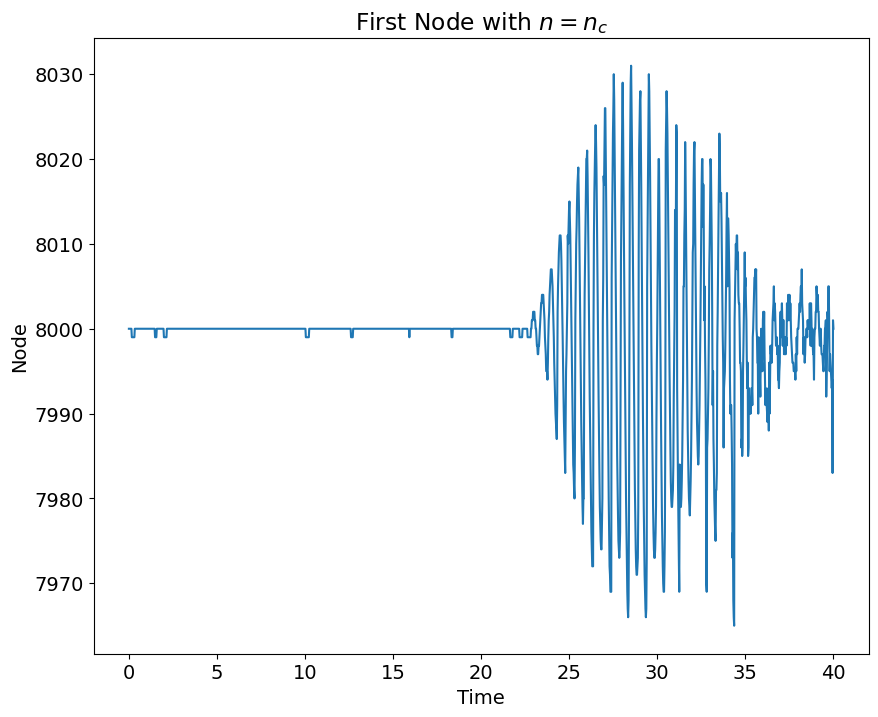

In [76]:
plt.plot(T, first)
plt.xlabel("Time")
plt.ylabel("Node")
plt.title("First Node with $n=n_c$")

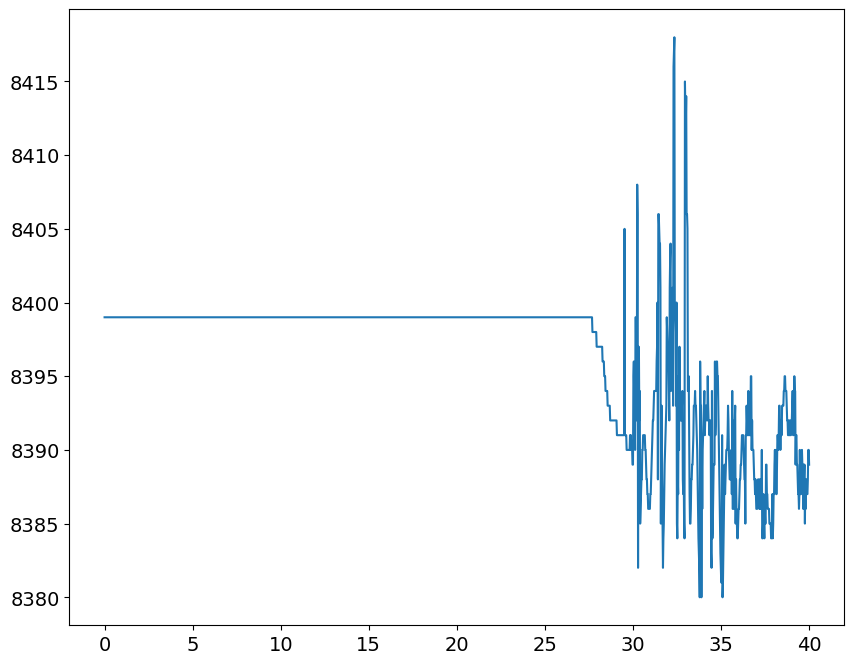

In [73]:
plt.plot(T, last)

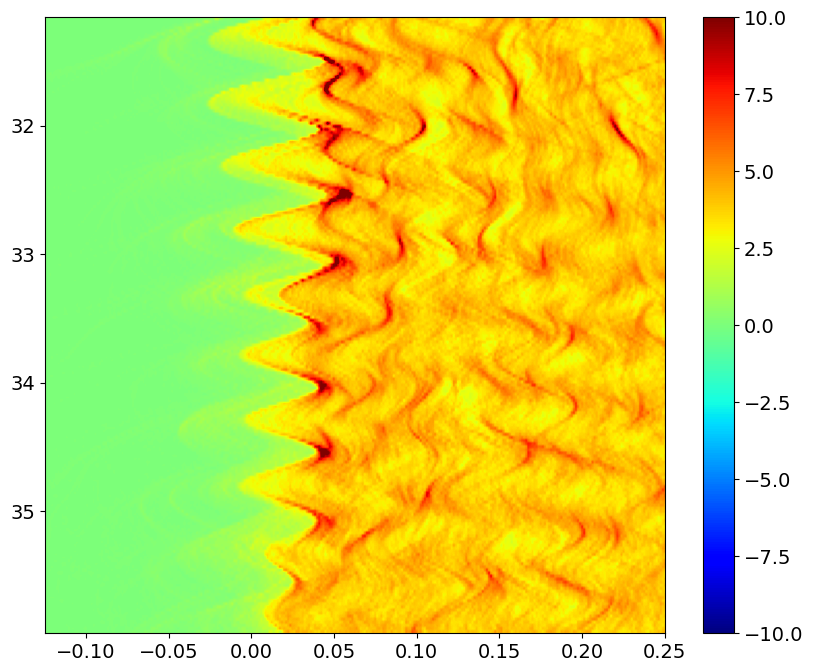

In [29]:
t_start = 1300
t_end = 1500
t_max = d.shape[0]
x_max = d.shape[1]
x_start = 2*3950
x_end = 2*4100
EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
plt.imshow(d[t_start:t_end, x_start:x_end], aspect="auto", extent=EXTENT, cmap="jet", vmax=10, vmin=-10)
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

In [36]:
d.shape

(1669, 16000)

(array([   0,    0,    0, ..., 1668, 1668, 1668]),
 array([ 7999,  8000,  8001, ..., 10827, 10828, 10829]))

# Before

In [17]:
node2 = 8000/NX*40
node1 = 4000/NX*40
node_t_1 = node1*tau
node_t_2 = node2*tau
node_t_1, node_t_2

(3.3356409519815204e-14, 6.671281903963041e-14)

## FT

In [18]:
Et0 = Et0 / np.max(Et0)
Et1 = Et1 / np.max(Et1)
Et2 = Et2 / np.max(Et2)
y0 = np.fft.fft(Et0)
y1 = np.fft.fft(Et1)
y2 = np.fft.fft(Et2)

In [19]:
y0_shift = np.fft.fftshift(y0)
y1_shift = np.fft.fftshift(y1)
y2_shift = np.fft.fftshift(y2)
y0_f = np.abs(y0_shift)
y1_f = np.abs(y1_shift)
y2_f = np.abs(y2_shift)

In [20]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

In [21]:
omega_max/omega0

41.69551189976901

(0.1, 1710.3056589373818)

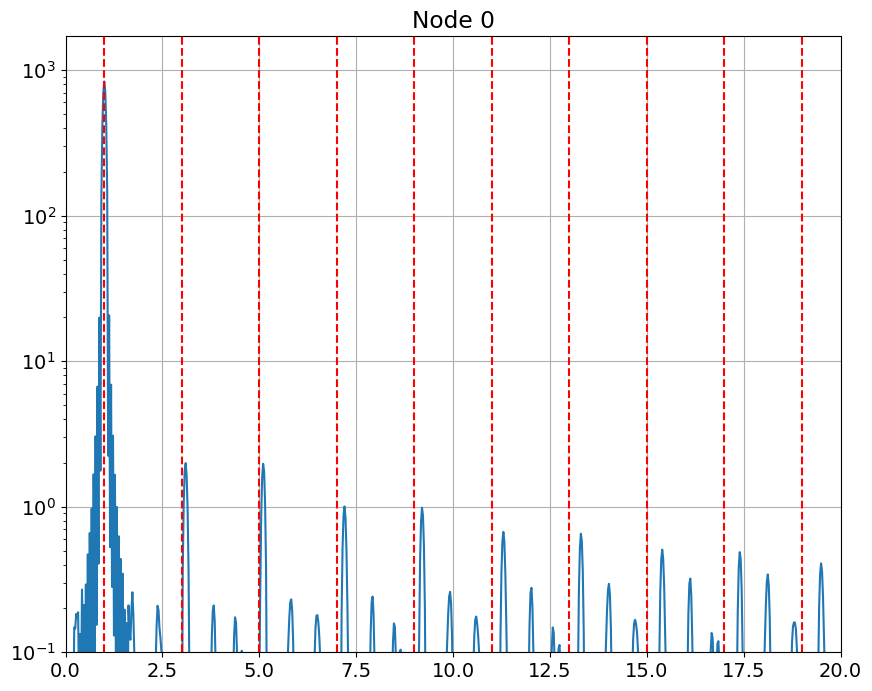

In [22]:
plt.plot(omega/omega0, 2*np.abs(y0_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()
plt.title("Node 0")
plt.ylim(0.1)

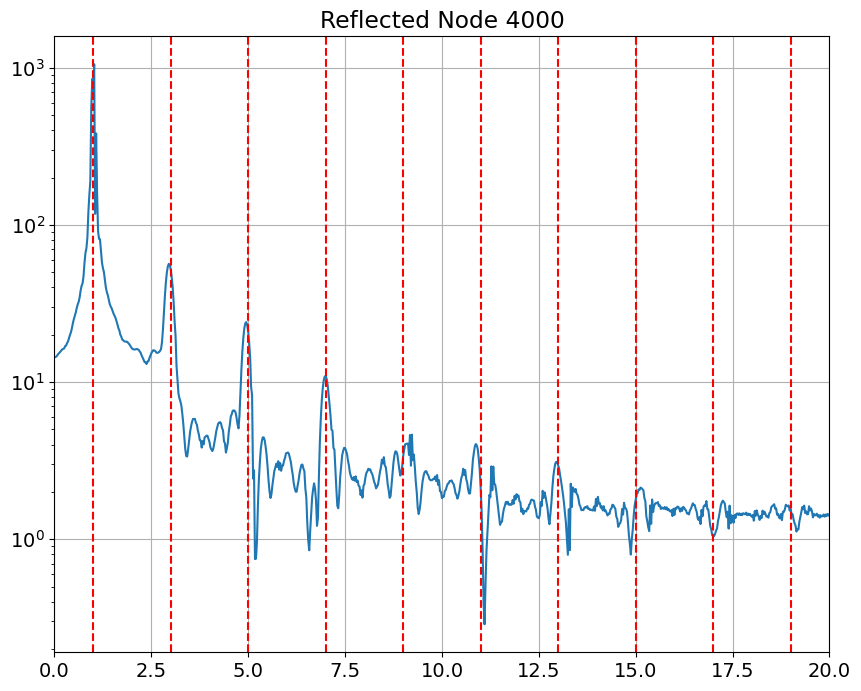

In [23]:
plt.plot(omega/omega0, 2*np.abs(y1_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()
plt.title("Reflected Node 4000");

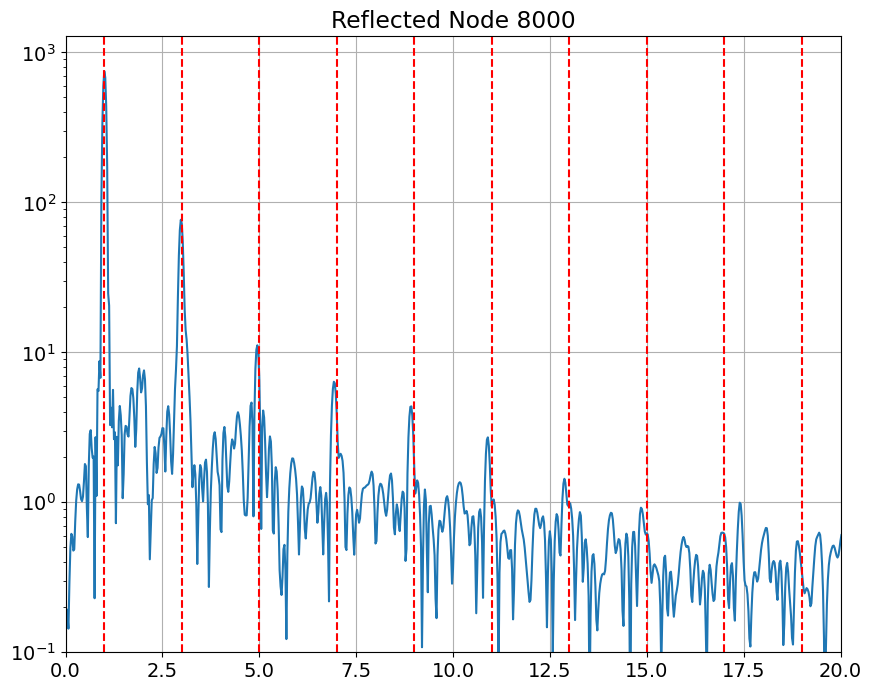

In [24]:
plt.plot(omega/omega0, 2*np.abs(y2_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()
plt.ylim(0.1)
plt.title("Reflected Node 8000");